## Exercice n°1 (1/2 h)




Dans le modèle ci-dessous, pouvez-vous préciser :
- la taille du champ réceptif associé à un pixel d'une carte de caractéristique en sortie de enc3, par un calcul théorique.
- passer ce modèle sur un champ ne contenant que des zéros sauf pour une composante. En déduire la taille du champ réceptif empirique en sortie du modèle.


In [1]:
import torch
import torch.nn as nn

class MyNN(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=16):
        super().__init__()

        # 2 Conv2D
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, base, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(base, base, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

        # 2 Conv2D, first with stride=2
        self.enc2 = nn.Sequential(
            nn.Conv2d(base, base * 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(base * 2, base * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

        # again 2 Conv2D, first with stride=2
        self.enc3 = nn.Sequential(
            nn.Conv2d(base * 2, base * 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(base * 4, base * 4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

        # alternance Conv2D / ConvTranspose2D
        self.mid = nn.Conv2d(base * 4, base * 4, kernel_size=3, padding=1, bias=False)

        self.up1 = nn.ConvTranspose2d(base * 4, base * 2, kernel_size=2, stride=2, bias=False)
        self.dec1 = nn.Conv2d(base * 2, base * 2, kernel_size=3, padding=1, bias=False)

        self.up2 = nn.ConvTranspose2d(base * 2, base, kernel_size=2, stride=2, bias=False)
        self.dec2 = nn.Conv2d(base, base, kernel_size=3, padding=1, bias=False)

        self.head = nn.Conv2d(base, out_ch, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)

        x = torch.relu(self.mid(x))

        x = self.up1(x)
        x = torch.relu(self.dec1(x))

        x = self.up2(x)
        x = torch.relu(self.dec2(x))

        return self.head(x)

La première question (réponse : 11) a été correctement abordée par la grande majorité des étudiants. C'est la deuxième question qui était plus subtile.
En effet, si la réponse à une impulsion prise au hasard donne effectivement un rectangle dont les dimensions sont proches du champ réceptif d'un pixel en sortie (voir cellule en dessous),  il convenait de noter que selon la position du pixel non nul, les dimensions du rectangle changeaient légèrement (comprises entre 34 et 38).
On pouvait un peut affiner l'analyse et préciser que, selon cette méthode, le champ réceptif d'un pixel en sortie pris au hasard se situait entre 34 et 40 (dernière cellule).

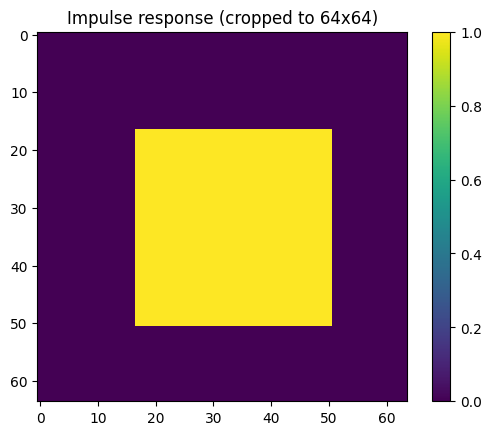

Support bbox in 64x64 crop: x=[17,50], y=[17,50]
Width=34, Height=34


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- your model definition must already be in scope (MyNN) ---

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

# 1) instantiate + pass a 128x128 image
model = MyNN(in_ch=3, out_ch=1, base=16).to(device).eval()

# 2) set all weights to positive values; keep biases at 0
with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" in name:
            p.abs_()                      # make strictly non-negative (keeps zeros as zeros)
        elif "bias" in name:
            p.zero_()                     # just in case (you used bias=False everywhere)

# 3) define an impulse at (x=64, y=64) on channel 0
x = torch.zeros(1, 3, 128, 128, device=device)
x[0, 0, 64, 64] = 1.0

# forward
with torch.no_grad():
    y = model(x)          # shape: (1, 1, 128, 128)

y2d = y[0, 0].detach().cpu() > 0

# 4) plot impulse answer in a 64x64 frame (crop away 32px margins on each side)
crop = y2d[32:96, 32:96]  # 64x64

plt.figure()
plt.imshow(crop, origin="upper")
plt.title("Impulse response (cropped to 64x64)")
plt.colorbar()
plt.show()

# 5) compute width/height of the output rectangle (support) inside the crop
# Use a tiny threshold to avoid numerical noise.
eps = 1e-12
mask = crop > eps
if mask.any():
    ys, xs = torch.where(mask)
    y_min, y_max = int(ys.min()), int(ys.max())
    x_min, x_max = int(xs.min()), int(xs.max())
    height = y_max - y_min + 1
    width  = x_max - x_min + 1
    print(f"Support bbox in 64x64 crop: x=[{x_min},{x_max}], y=[{y_min},{y_max}]")
    print(f"Width={width}, Height={height}")
else:
    print("No nonzero support found in the crop (mask is empty).")


Dans la cellule suivante on calcule les dimensions du support rectangulaire de la réponse à l'impulsion selon les coordonnées du pixel "chargé". Compte tenu des deux stride de 2 dans l'encodeur, il suffit de connaître ces variations pour des delta_x et delta_y compris entre 0 et 4 exclus.

In [10]:
import torch

eps = 1e-12

print("| k | j | width | height |")
print("|---|---|-------|--------|")

with torch.no_grad():
    for k in range(0,4):
        for j in range(0,4):
            # impulse
            x = torch.zeros(1, 3, 128, 128, device=device)
            x[0, 0, 64 + k, 64 + j] = 1.0

            y = model(x)[0, 0].cpu()


            mask = y > eps
            if mask.any():
                ys, xs = torch.where(mask)
                height = int(ys.max() - ys.min() + 1)
                width  = int(xs.max() - xs.min() + 1)
            else:
                height = width = 0

            print(f"| {k} | {j} | {width} | {height} |")


| k | j | width | height |
|---|---|-------|--------|
| 0 | 0 | 34 | 34 |
| 0 | 1 | 38 | 34 |
| 0 | 2 | 38 | 34 |
| 0 | 3 | 38 | 34 |
| 1 | 0 | 34 | 38 |
| 1 | 1 | 38 | 38 |
| 1 | 2 | 38 | 38 |
| 1 | 3 | 38 | 38 |
| 2 | 0 | 34 | 38 |
| 2 | 1 | 38 | 38 |
| 2 | 2 | 38 | 38 |
| 2 | 3 | 38 | 38 |
| 3 | 0 | 34 | 38 |
| 3 | 1 | 38 | 38 |
| 3 | 2 | 38 | 38 |
| 3 | 3 | 38 | 38 |


| k | j | width | height |
|---|---|-------|--------|
| 0 | 0 | 34 | 34 |
| 0 | 1 | 38 | 34 |
| 0 | 2 | 38 | 34 |
| 0 | 3 | 38 | 34 |
| 1 | 0 | 34 | 38 |
| 1 | 1 | 38 | 38 |
| 1 | 2 | 38 | 38 |
| 1 | 3 | 38 | 38 |
| 2 | 0 | 34 | 38 |
| 2 | 1 | 38 | 38 |
| 2 | 2 | 38 | 38 |
| 2 | 3 | 38 | 38 |
| 3 | 0 | 34 | 38 |
| 3 | 1 | 38 | 38 |
| 3 | 2 | 38 | 38 |
| 3 | 3 | 38 | 38 |


Pour affiner un peu, on peut évaluer la distance algébrique entre la coordonnée du point chargé et celle des bords du support rectangulaire en sortie. Cela nous permet de savoir, pour un pixel quelconque en sortie, à quelles distances peuvent être situés, au maximum, les points qui l'on influencé.

In [13]:
eps = 1e-12

print("| k | j | left | right | up | down |")
print("|---|---|------|-------|----|------|")

with torch.no_grad():
    for k in range(4):
        for j in range(4):
            # impulse
            x = torch.zeros(1, 3, 128, 128, device=device)
            x0, y0 = 64 + k, 64 + j
            x[0, 0, x0, y0] = 1.0

            y = model(x)[0, 0].cpu()

            mask = y > eps
            if mask.any():
                ys, xs = torch.where(mask)
                y_min, y_max = int(ys.min()), int(ys.max())
                x_min, x_max = int(xs.min()), int(xs.max())

                left  = y0 - x_min
                right = x_max - y0
                up    = x0 - y_min
                down  = y_max - x0
            else:
                left = right = up = down = 0

            print(f"| {k} | {j} | {left} | {right} | {up} | {down} |")


| k | j | left | right | up | down |
|---|---|------|-------|----|------|
| 0 | 0 | 15 | 18 | 15 | 18 |
| 0 | 1 | 16 | 21 | 15 | 18 |
| 0 | 2 | 17 | 20 | 15 | 18 |
| 0 | 3 | 18 | 19 | 15 | 18 |
| 1 | 0 | 15 | 18 | 16 | 21 |
| 1 | 1 | 16 | 21 | 16 | 21 |
| 1 | 2 | 17 | 20 | 16 | 21 |
| 1 | 3 | 18 | 19 | 16 | 21 |
| 2 | 0 | 15 | 18 | 17 | 20 |
| 2 | 1 | 16 | 21 | 17 | 20 |
| 2 | 2 | 17 | 20 | 17 | 20 |
| 2 | 3 | 18 | 19 | 17 | 20 |
| 3 | 0 | 15 | 18 | 18 | 19 |
| 3 | 1 | 16 | 21 | 18 | 19 |
| 3 | 2 | 17 | 20 | 18 | 19 |
| 3 | 3 | 18 | 19 | 18 | 19 |


| k | j | left | right | up | down |
|---|---|------|-------|----|------|
| 0 | 0 | 15 | 18 | 15 | 18 |
| 0 | 1 | 16 | 21 | 15 | 18 |
| 0 | 2 | 17 | 20 | 15 | 18 |
| 0 | 3 | 18 | 19 | 15 | 18 |
| 1 | 0 | 15 | 18 | 16 | 21 |
| 1 | 1 | 16 | 21 | 16 | 21 |
| 1 | 2 | 17 | 20 | 16 | 21 |
| 1 | 3 | 18 | 19 | 16 | 21 |
| 2 | 0 | 15 | 18 | 17 | 20 |
| 2 | 1 | 16 | 21 | 17 | 20 |
| 2 | 2 | 17 | 20 | 17 | 20 |
| 2 | 3 | 18 | 19 | 17 | 20 |
| 3 | 0 | 15 | 18 | 18 | 19 |
| 3 | 1 | 16 | 21 | 18 | 19 |
| 3 | 2 | 17 | 20 | 18 | 19 |
| 3 | 3 | 18 | 19 | 18 | 19 |

Sans aller plus dans le détail, le tableau ci-dessus permet de dire qu'un pixel en sortie peut être affecté par un pixel situé à +18 à sa droite, -21 à sa gauche, +18 au dessus ou -21 en dessous, soient un champ réceptif de taille compris entre 34 et 40.

**NB** : Cette méthode suggérée par l'énoncé n'est pas la plus naturelle : il est plus simple (et plus précis) de passer par les gradients d'une fonction de coût calculée en un point particulier du champ de sortie. Mais même en passant par les gradients, on trouvera que les dimensions du support varient en fonction du point choisi.